<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импортируем-необходимые-библиотеки-и-модули" data-toc-modified-id="Импортируем-необходимые-библиотеки-и-модули-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импортируем необходимые библиотеки и модули</a></span></li><li><span><a href="#Взглянем-на-данные-и-визуализируем-распределение-признаков" data-toc-modified-id="Взглянем-на-данные-и-визуализируем-распределение-признаков-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Взглянем на данные и визуализируем распределение признаков</a></span></li><li><span><a href="#Подготовка-текста-для-обучения-модели" data-toc-modified-id="Подготовка-текста-для-обучения-модели-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Подготовка текста для обучения модели</a></span></li><li><span><a href="#Подготовка-выборок-для-обучения-модели-и-ее-тестирования" data-toc-modified-id="Подготовка-выборок-для-обучения-модели-и-ее-тестирования-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Подготовка выборок для обучения модели и ее тестирования</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Перевод-текста-в-векторный-вид" data-toc-modified-id="Перевод-текста-в-векторный-вид-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Перевод текста в векторный вид</a></span></li><li><span><a href="#Обучение-и-тестирование-логистической-регрессии" data-toc-modified-id="Обучение-и-тестирование-логистической-регрессии-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Обучение и тестирование логистической регрессии</a></span></li><li><span><a href="#Обучение-и-тестирование-гребневой-классификации" data-toc-modified-id="Обучение-и-тестирование-гребневой-классификации-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Обучение и тестирование гребневой классификации</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Импортируем необходимые библиотеки и модули

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import re


from matplotlib import pyplot as plt
import seaborn as sns

from tqdm import tqdm, tqdm_notebook, notebook

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords 

### Взглянем на данные и визуализируем распределение признаков

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


<AxesSubplot:title={'center':'Баланс токсичных комментариев'}>

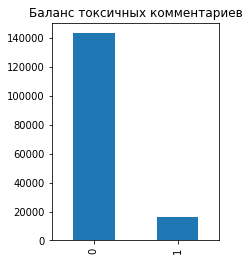

In [2]:
# выведем первые 5 строк таблицы
data = pd.read_csv('/datasets/toxic_comments.csv')
display(data.head(5))

# проведем визуализацию баланса целевого признака
plt.title('Баланс токсичных комментариев')
data['toxic'].value_counts().plot(kind = 'bar', figsize = (3,4))

<b>ПРОМЕЖУТОЧНЫЙ ВЫВОД:</b> виднеется сильный дисбаланс классов. Добавим метапризнаки для более детального анализа данных

In [3]:
# создадим функцию добавления метапризнаков
def add_features(data,stopwords):
    data['word_count'] = data['text'].apply(lambda x: len(str(x).split()))
    data['word_unique_count'] = data['text'].apply(lambda x: len(set(str(x).split())))
    data['symbol_count'] = data['text'].apply(lambda x: len(str(x)))
    data['mean_word_length'] = data['text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))
    return data

#применим функцию и сохраним результат в новой переменной
data_changed = add_features(data, stopwords)
data_changed.head(5)

,text,toxic,word_count,word_unique_count,symbol_count,mean_word_length
0,Explanation\nWhy the edits made under my usern...,0,43,41,264,5.162791
1,D'aww! He matches this background colour I'm s...,0,17,17,112,5.588235
2,"Hey man, I'm really not trying to edit war. It...",0,42,39,233,4.571429
3,"""\nMore\nI can't make any real suggestions on ...",0,113,82,622,4.486726
4,"You, sir, are my hero. Any chance you remember...",0,13,13,67,4.230769


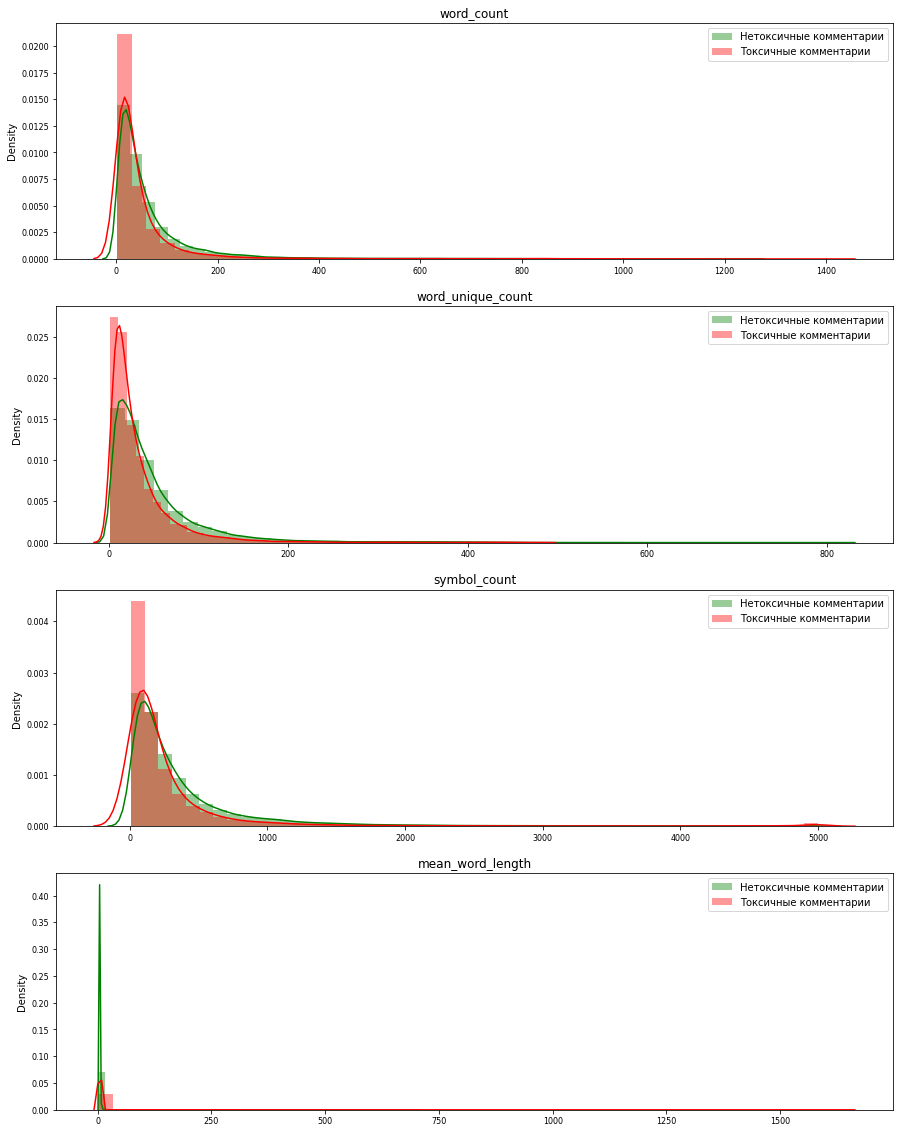

In [4]:
# визуализируем распределение метапризнаков
additional_features = ['word_count', 'word_unique_count', 'symbol_count', 'mean_word_length']
TOXIC_COMMENTS = data_changed['toxic'] == 1

fig, axes = plt.subplots(nrows=len(additional_features), figsize=(15, 20))

for i, feature in enumerate(additional_features):
    sns.distplot(data.loc[~TOXIC_COMMENTS][feature], label='Нетоксичные комментарии', ax=axes[i], color='green')
    sns.distplot(data.loc[TOXIC_COMMENTS][feature], label='Токсичные комментарии', ax=axes[i], color='red')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelsize=8)
    axes[i].tick_params(axis='y', labelsize=8)
    axes[i].legend(fontsize = 10)
    axes[i].set_title(feature, fontsize=12)

plt.show()

<b>ВЫВОД:</b> токсичные комментарии содержат в себе больше слов, в т.ч. уникальных и длиннее по количеству символов. А вот средняя длина каждого слова короче, видимо, экспрессия может быть выражена коротко, но емко.

### Подготовка текста для обучения модели

Этапы подготовки идут последовательно:
1) очистка текста от лишних символов и перевод в нижний регистр

2) токенизация текста

3) очистка от несмысловых стоп-слов

4) лемматизация оставшихся лексических единиц

In [5]:
# создадим функцию для очистки текста
def clean(text):
    text = text.lower()    
    text = re.sub(r"(?:\n|\r)", " ", text)
    text = re.sub(r"[^a-zA-Z ]+", "", text).strip()
    return text
data_changed['clean_text'] = data_changed['text'].apply(clean)
data_changed.head(5)

,text,toxic,word_count,word_unique_count,symbol_count,mean_word_length,clean_text
0,Explanation\nWhy the edits made under my usern...,0,43,41,264,5.162791,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,17,17,112,5.588235,daww he matches this background colour im seem...
2,"Hey man, I'm really not trying to edit war. It...",0,42,39,233,4.571429,hey man im really not trying to edit war its j...
3,"""\nMore\nI can't make any real suggestions on ...",0,113,82,622,4.486726,more i cant make any real suggestions on impro...
4,"You, sir, are my hero. Any chance you remember...",0,13,13,67,4.230769,you sir are my hero any chance you remember wh...


In [6]:
#создадим функцию для токенизации текста
def tokenization(text):
    text = re.split('\W+', text)
    return text

data_changed['tokenized_text'] = data_changed['clean_text'].apply(lambda x: tokenization(x))
data_changed.head(5)

,text,toxic,word_count,word_unique_count,symbol_count,mean_word_length,clean_text,tokenized_text
0,Explanation\nWhy the edits made under my usern...,0,43,41,264,5.162791,explanation why the edits made under my userna...,"[explanation, why, the, edits, made, under, my..."
1,D'aww! He matches this background colour I'm s...,0,17,17,112,5.588235,daww he matches this background colour im seem...,"[daww, he, matches, this, background, colour, ..."
2,"Hey man, I'm really not trying to edit war. It...",0,42,39,233,4.571429,hey man im really not trying to edit war its j...,"[hey, man, im, really, not, trying, to, edit, ..."
3,"""\nMore\nI can't make any real suggestions on ...",0,113,82,622,4.486726,more i cant make any real suggestions on impro...,"[more, i, cant, make, any, real, suggestions, ..."
4,"You, sir, are my hero. Any chance you remember...",0,13,13,67,4.230769,you sir are my hero any chance you remember wh...,"[you, sir, are, my, hero, any, chance, you, re..."


In [7]:
# создадим переменную со стоп-словами
stopword = nltk.corpus.stopwords.words('english')

#создадим функцию для удаления стоп-слов
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
data_changed['nonstop_words'] = data_changed['tokenized_text'].apply(lambda x: remove_stopwords(x))
data_changed.head(5)

,text,toxic,word_count,word_unique_count,symbol_count,mean_word_length,clean_text,tokenized_text,nonstop_words
0,Explanation\nWhy the edits made under my usern...,0,43,41,264,5.162791,explanation why the edits made under my userna...,"[explanation, why, the, edits, made, under, my...","[explanation, edits, made, username, hardcore,..."
1,D'aww! He matches this background colour I'm s...,0,17,17,112,5.588235,daww he matches this background colour im seem...,"[daww, he, matches, this, background, colour, ...","[daww, matches, background, colour, im, seemin..."
2,"Hey man, I'm really not trying to edit war. It...",0,42,39,233,4.571429,hey man im really not trying to edit war its j...,"[hey, man, im, really, not, trying, to, edit, ...","[hey, man, im, really, trying, edit, war, guy,..."
3,"""\nMore\nI can't make any real suggestions on ...",0,113,82,622,4.486726,more i cant make any real suggestions on impro...,"[more, i, cant, make, any, real, suggestions, ...","[cant, make, real, suggestions, improvement, w..."
4,"You, sir, are my hero. Any chance you remember...",0,13,13,67,4.230769,you sir are my hero any chance you remember wh...,"[you, sir, are, my, hero, any, chance, you, re...","[sir, hero, chance, remember, page, thats]"


In [8]:
# создадим функцию лемматизации очищенного текста
wn_lemm = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn_lemm.lemmatize(word) for word in text]
    return text

data_changed['lemmatized'] = data_changed['nonstop_words'].apply(lambda x: lemmatizer(x))
data_changed.head(5)

,text,toxic,word_count,word_unique_count,symbol_count,mean_word_length,clean_text,tokenized_text,nonstop_words,lemmatized
0,Explanation\nWhy the edits made under my usern...,0,43,41,264,5.162791,explanation why the edits made under my userna...,"[explanation, why, the, edits, made, under, my...","[explanation, edits, made, username, hardcore,...","[explanation, edits, made, username, hardcore,..."
1,D'aww! He matches this background colour I'm s...,0,17,17,112,5.588235,daww he matches this background colour im seem...,"[daww, he, matches, this, background, colour, ...","[daww, matches, background, colour, im, seemin...","[daww, match, background, colour, im, seemingl..."
2,"Hey man, I'm really not trying to edit war. It...",0,42,39,233,4.571429,hey man im really not trying to edit war its j...,"[hey, man, im, really, not, trying, to, edit, ...","[hey, man, im, really, trying, edit, war, guy,...","[hey, man, im, really, trying, edit, war, guy,..."
3,"""\nMore\nI can't make any real suggestions on ...",0,113,82,622,4.486726,more i cant make any real suggestions on impro...,"[more, i, cant, make, any, real, suggestions, ...","[cant, make, real, suggestions, improvement, w...","[cant, make, real, suggestion, improvement, wo..."
4,"You, sir, are my hero. Any chance you remember...",0,13,13,67,4.230769,you sir are my hero any chance you remember wh...,"[you, sir, are, my, hero, any, chance, you, re...","[sir, hero, chance, remember, page, thats]","[sir, hero, chance, remember, page, thats]"


<b>ПРОМЕЖУТОЧНЫЙ ВЫВОД:</b> теперь таблица содержит все необходимые столбцы, текст очищен и лемматизирован. Можно приступать к разбиению данных на выборки.

### Подготовка выборок для обучения модели и ее тестирования

In [9]:
data_train, data_test = train_test_split(data_changed, test_size = 0.2,shuffle = True, random_state = 42)
X_train, X_test = data_train.drop('toxic', axis = 1), data_test.drop('toxic', axis = 1)
y_train, y_test = data_train['toxic'], data_test['toxic']

#проверим размерность выборок
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(127656, 9) (31915, 9) (127656,) (31915,)


## Обучение
Выделим здесь три этапа:
1) Векторизация текста

2) Обучение модели с подбором гиперпараметров

3) Проверка модели на тестовой выборке

### Перевод текста в векторный вид

In [10]:
# объявим векторизатор
count_tf_idf = TfidfVectorizer()

# сменим кодировку корпусов
train_corpus = X_train.astype('U')
test_corpus = X_test.astype('U')

#обучим векторизатор на трейне и сразу же трансформируем его
tfidf_train = count_tf_idf.fit_transform(train_corpus['lemmatized']) 
#векторизируем предобученным векторизатором тестовый корпус
tfidf_test = count_tf_idf.transform(test_corpus['lemmatized'])

In [11]:
# создадим список для сохранения результатов работы моделей
models = ['Logistic Regression', 'Ridge Regression']
results = []

### Обучение и тестирование логистической регрессии

In [12]:
# объявим модель без учета гиперпараметров
model = LogisticRegression(random_state = 42)
# обучим ЛР на трейне
model.fit(tfidf_train, y_train)
# получим предсказания
predictions = model.predict(tfidf_test)
# рассчитаем метрику f1 на тесте
result = f1_score(y_test, predictions)
print('F1 Score базовой модели логистической регрессии равен:', result)

F1 Score базовой модели логистической регрессии равен: 0.744177449168207


<b>ПРОМЕЖУТОЧНЫЙ ВЫВОД:</b> даже без подбора гиперпараметров базовая логистическая регрессия дает неплохой показатель, чуть ниже необходимого порога. Попробуем найти подходящие параметры для повышения качества предсказаний.

In [13]:
params = {'class_weight':['balanced', None], 'C':[1,10,100],}
grid_LR = GridSearchCV(model,
                        params,
                        cv= 5,
                        scoring='f1',
                        verbose=100)
#grid_LR.fit(tfidf_train, y_train)
#print(grid_LR.best_params_)
#print(grid_LR.best_score_)

<b>ВЫВОД:</b> после подбора гиперпараметров наилучший результат 0.77 на трейне дали параметры {'C': 10, 'class_weight': 'balanced'}
Проверим эти параметры модели на тестовой выборке

In [14]:
model_LR_best = LogisticRegression(random_state = 42, C = 10, class_weight = 'balanced')
# обучим ЛР на трейне
model_LR_best.fit(tfidf_train, y_train)
# получим предсказания
predictions = model_LR_best.predict(tfidf_test)
# рассчитаем метрику f1 на тесте
result = f1_score(y_test, predictions)
results.append(result)
print('F1 Score логистической регрессии с подбором гиперпараметров равен:', result)

F1 Score логистической регрессии с подбором гиперпараметров равен: 0.7745182628702906


### Обучение и тестирование гребневой классификации

In [15]:
# объявим модель без учета гиперпараметров
model = RidgeClassifier(random_state = 42)
# обучим ЛР на трейне
model.fit(tfidf_train, y_train)
# получим предсказания
predictions = model.predict(tfidf_test)
# рассчитаем метрику f1 на тесте
result = f1_score(y_test, predictions)
print('F1 Score базовой модели гребневой классификации равен:', result)

F1 Score базовой модели гребневой классификации равен: 0.7105613701236918


In [16]:
params = {'class_weight':['balanced', None], 'alpha':[0.1, 1, 10],}
grid_ridge = GridSearchCV(model,
                        params,
                        cv= 3,
                        scoring='f1',
                        verbose=100)
#grid_ridge.fit(tfidf_train, y_train)
#print(grid_ridge.best_params_)
#print(grid_ridge.best_score_)

<b>ПРОМЕЖУТОЧНЫЙ ВЫВОД:</b> лучший показатель 0.675 при {'alpha': 1, 'class_weight': None}

In [17]:
model_ridge_best = RidgeClassifier(random_state = 42, alpha = 1, class_weight = None)
# обучим ЛР на трейне
model_ridge_best.fit(tfidf_train, y_train)
# получим предсказания
predictions = model_ridge_best.predict(tfidf_test)
# рассчитаем метрику f1 на тесте
result = f1_score(y_test, predictions)
results.append(result)
print('F1 Score гребневой классификации с подбором гиперпараметров равен:', result)

F1 Score гребневой классификации с подбором гиперпараметров равен: 0.7105613701236918


## Выводы

In [18]:
# визуализируем данные в виде таблицы
pd.DataFrame(index = models, columns = ['F1 score'], data = results)

,F1 score
Logistic Regression,0.774518
Ridge Regression,0.710561


<b>ВЫВОД:</b> логистическая регрессия показала себя лучше, чем гребневый классификатор. Необходимый порог достигнут с показателем f1 0.7745

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны